#Load data

In [5]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# data_path = 'data/casia-webface'
data_path = 'data/webface-10'

batch_size = 30

train_data = datasets.ImageFolder(data_path, transform=transform)

trainloader = torch.utils.data.DataLoader(
    train_data, shuffle=True, batch_size=batch_size)

Make sure dataset is loaded correctly

In [70]:
iterator = iter(trainloader)
image, label = next(iterator)

print("image", image[0])
print("label", label[0])
print("label", label[1])
print("label", label[2])
print("label", label[3])

image tensor([[[0.0902, 0.0863, 0.0745,  ..., 0.1608, 0.1608, 0.1608],
         [0.0863, 0.0824, 0.0745,  ..., 0.1608, 0.1647, 0.1647],
         [0.0824, 0.0784, 0.0706,  ..., 0.1647, 0.1686, 0.1686],
         ...,
         [0.4196, 0.4157, 0.4118,  ..., 0.2745, 0.2941, 0.3059],
         [0.4275, 0.4235, 0.4157,  ..., 0.2784, 0.2980, 0.3098],
         [0.4314, 0.4275, 0.4196,  ..., 0.2824, 0.3020, 0.3098]],

        [[0.0784, 0.0745, 0.0627,  ..., 0.1686, 0.1686, 0.1686],
         [0.0745, 0.0706, 0.0627,  ..., 0.1686, 0.1725, 0.1725],
         [0.0706, 0.0667, 0.0588,  ..., 0.1725, 0.1765, 0.1765],
         ...,
         [0.2706, 0.2706, 0.2667,  ..., 0.3137, 0.3333, 0.3451],
         [0.2784, 0.2784, 0.2745,  ..., 0.3176, 0.3373, 0.3490],
         [0.2824, 0.2824, 0.2784,  ..., 0.3216, 0.3412, 0.3490]],

        [[0.0588, 0.0549, 0.0431,  ..., 0.1647, 0.1647, 0.1647],
         [0.0549, 0.0510, 0.0431,  ..., 0.1647, 0.1686, 0.1686],
         [0.0510, 0.0471, 0.0392,  ..., 0.1686, 0.17

#Init the model

In [71]:
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn, optim
import os
# model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = resnet18()
num_classes = len(os.listdir(data_path))
print(num_classes)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

model.fc = nn.Linear(512, num_classes)
model.to(device)


10
mps


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#Train the model

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [73]:
import time

learning_rate = 1e-3
num_epochs = 50
weight_decay = 0.0
momentum = 0.9

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                    lr=learning_rate,
                    momentum=momentum,
                    weight_decay=weight_decay)

def get_train_accuracy(model: nn.Module):
    correct = 0
    total = 0
    n = 0
    with torch.no_grad():
        for imgs, labels in iter(trainloader):
            imgs, labels = imgs.to(device), labels.to(device) # Move input data to the same device as the model
            model.eval()
            output = model(imgs) # We don't need to run torch.softmax
            pred = output.max(1)[1] # get the index of the max log-probability
            correct += pred.eq(labels).sum().item()
            total += imgs.shape[0]
            n += 1
    return correct / total 

for epoch in range(num_epochs):
    n = 0
    for imgs, labels in iter(trainloader):
        tic = time.perf_counter()
        # imshow(imgs[0])
        imgs = imgs.to(device)
        labels = labels.to(device)

        model.train() # annotate model for training

        out = model(imgs)
        loss = loss_fn(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        toc = time.perf_counter()
        n += 1
        if n % 10 == 0:
            print('epoch: {}, iter: {}, loss: {}, time: {}'.format(epoch, n, loss, toc - tic))
    print(get_train_accuracy(model))

epoch: 0, iter: 10, loss: 0.6927081346511841, time: 0.156260833988199
epoch: 0, iter: 20, loss: 1.129655361175537, time: 0.14492441702168435
epoch: 0, iter: 30, loss: 0.7063019275665283, time: 0.1568414580251556
epoch: 0, iter: 40, loss: 0.511684238910675, time: 0.1556372919876594
0.7530077848549186
epoch: 1, iter: 10, loss: 0.6358378529548645, time: 0.15831450000405312
epoch: 1, iter: 20, loss: 0.7424553036689758, time: 0.15696091699646786
epoch: 1, iter: 30, loss: 0.62321937084198, time: 0.15940183299244381
epoch: 1, iter: 40, loss: 0.7402925491333008, time: 0.15687870897818357
0.7020523708421798
epoch: 2, iter: 10, loss: 0.6190826296806335, time: 0.15784075000556186
epoch: 2, iter: 20, loss: 0.7175543904304504, time: 0.15832395799225196
epoch: 2, iter: 30, loss: 0.6209840178489685, time: 0.1564303750055842
epoch: 2, iter: 40, loss: 0.7267182469367981, time: 0.1564564159780275
0.7820240622788394
epoch: 3, iter: 10, loss: 0.38727331161499023, time: 0.15525974999764003
epoch: 3, iter: 

KeyboardInterrupt: 

In [57]:
print(len(os.listdir('./data/webface-10')))
print(len(os.listdir('./data/webface-small')))
print(len(os.listdir('./data/casia-webface')))

10
101
10572


Test showing a picture and running model

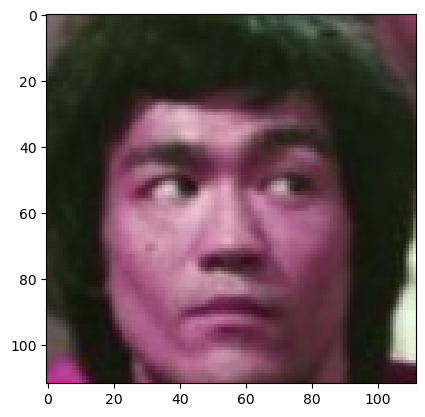

NameError: name 'model' is not defined

In [7]:
from PIL import Image

img = Image.open('./data/webface-10/000000/00000001.jpg')
timg = transforms.ToTensor()(img)
imshow(timg)
model(timg)